In [1]:
# All Imports
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
from sklearn.model_selection import train_test_split


In [2]:
# Coincap aoi to get bitcoin data
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday'
response = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1999&api_key=346a5653477eed39d369f3b05523c27a427a45ab31125be8a8dbf06cf4478d49')
dataTable = pd.DataFrame(json.loads(response.content)['Data']['Data'])
dataTable = dataTable.set_index('time')
dataTable.index = pd.to_datetime(dataTable.index, unit='s')
target_col = 'close'

In [3]:
dataTable.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [4]:
# print first 5 
dataTable.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-04-16,432.00,426.84,428.67,29021.18,12517265.78,430.05
2016-04-17,430.62,423.79,430.05,25586.86,10980868.31,426.26
2016-04-18,429.07,424.35,426.26,32574.71,13951524.85,427.69
2016-04-19,436.07,426.84,427.69,45675.40,19713466.34,434.92
2016-04-20,442.86,432.51,434.92,74361.53,32655415.81,441.16


In [5]:
# print last 5
dataTable.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-10-02,48347.69,47468.49,48164.35,16062.18,7.690222e+08,47669.02
2021-10-03,49185.34,47137.07,47669.02,18588.83,8.956068e+08,48234.05
2021-10-04,49501.21,46944.28,48234.05,34394.00,1.664028e+09,49276.91
2021-10-05,51885.03,49087.72,49276.91,40687.89,2.049372e+09,51504.27
2021-10-06,51521.80,50939.38,51504.27,3018.57,1.547207e+08,51277.93


In [6]:
# training 60%, validation 20%, testing 20%
def data_split(dt, test_size=0.2, validation_size=0.25):
    remaining, test = train_test_split(dt, test_size=test_size, shuffle=False)
    train,validation  = train_test_split(remaining, test_size=validation_size, shuffle=False) # 0.25 x 0.8 = 0.2
    return train, validation, test

In [7]:
train, validation, test  = data_split(dataTable, test_size=0.2, validation_size=0.25)

In [8]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

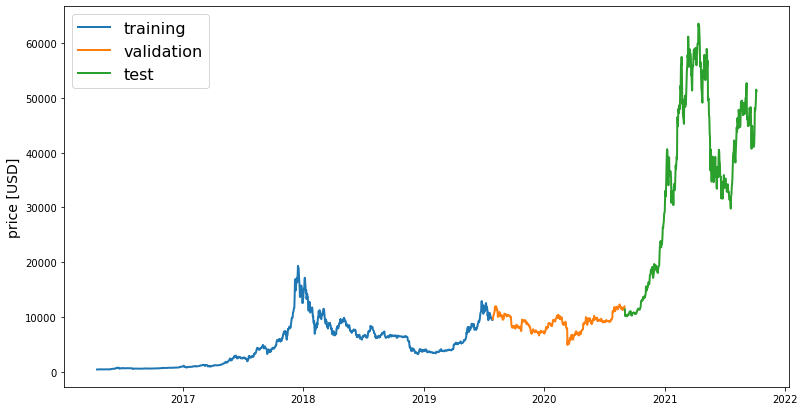

In [9]:
line_plot(train[target_col], validation[target_col], test[target_col], 'training', 'validation', 'test')

In [39]:
#normalizing the data
def normalise_zero_base(dt):
    return dt / dt.iloc[0] - 1

def normalise_min_max(dt):
    return (dt - dt.min()) / (dt.max() - dt.min())

In [40]:
def extract_window_data(dt, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(dt) - window_len):
        tmp = dt[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [47]:
def prepare_data(dt, target_col, window_len=10, zero_base=True, test_size=0.2, validation_size=0.25):
    
    train_d, validation_d, test_d = data_split(dt, test_size=test_size,validation_size=validation_size)
#     print(test_d)
    X_train = extract_window_data(train_d, window_len, zero_base)
    X_validation = extract_window_data(validation_d, window_len, zero_base)
    X_test = extract_window_data(test_d, window_len, zero_base)
#     print("X_test",X_test)
    y_train = train_d[target_col][window_len:].values
    y_validation = validation_d[target_col][window_len:].values
    y_test = test_d[target_col][window_len:].values
#     print("y_test",y_test)
    if zero_base:
        y_train = y_train / train_d[target_col][:-window_len].values - 1
        y_validation = y_validation / validation_d[target_col][:-window_len].values - 1
        y_test = y_test / test_d[target_col][:-window_len].values - 1

    return train_d, validation_d, test_d, X_train, X_validation, X_test, y_train, y_validation, y_test

In [48]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [49]:
np.random.seed(42)
window_len = 5
test_size = 0.2
validation_size=0.25
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [59]:
train_d, validation_d, test_d, X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_data(
    dataTable, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size, validation_size=validation_size)

In [60]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
38/38 [==============================] - 1s 33ms/step - loss: 0.1093 - val_loss: 0.0106
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0781 - val_loss: 0.0065
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0648 - val_loss: 0.0066
Epoch 4/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0623 - val_loss: 0.0065
Epoch 5/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0527 - val_loss: 0.0066
Epoch 6/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0418 - val_loss: 0.0085
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0067
Epoch 8/20
38/38 [==============================] - 0s 6ms/step - loss: 0.0326 - val_loss: 0.0069
Epoch 9/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0262 - val_loss: 0.0065
Epoch 10/20
38/38 [==============================] - 0s 7ms/step - loss: 0.0217 - val_loss: 0.0065
Epoch 11/20
38/38 

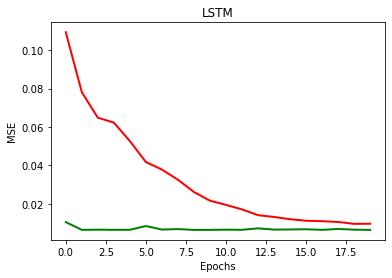

In [61]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [62]:
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss, test acc:", results)

13/13 [==============================] - 0s 3ms/step - loss: 0.0086
test loss, test acc: 0.008621243759989738


In [63]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.07188355876981738

In [64]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.008621243809213147

In [65]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

-0.03082263436463717

time
2020-09-07    10379.08
2020-09-08    10128.54
2020-09-09    10228.85
2020-09-10    10345.68
2020-09-11    10398.50
                ...   
2021-10-02    47669.02
2021-10-03    48234.05
2021-10-04    49276.91
2021-10-05    51504.27
2021-10-06    51277.93
Name: close, Length: 395, dtype: float64
time
2020-09-07    11488.181184
2020-09-08    10255.211753
2020-09-09    10550.240269
2020-09-10    10248.509080
2020-09-11    10341.640967
                  ...     
2021-10-02    42521.671413
2021-10-03    41381.995137
2021-10-04    41868.458061
2021-10-05    44176.506121
2021-10-06    48545.853133
Length: 395, dtype: float64


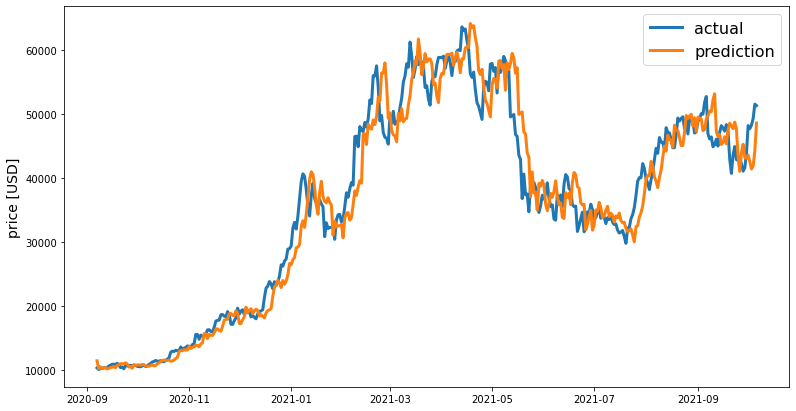

In [66]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
print(targets)
print(preds)
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(targets, label='actual', linewidth=3)
ax.plot(preds, label='prediction', linewidth=3)
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title("", fontsize=16)
ax.legend(loc='best', fontsize=16)
# line_plot(targets, preds, 'actual', 'prediction', lw=3)